## Narzędzie graficzne

In [1]:
import math

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import pandas as pd

TOLERANCE = 0.20

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points
        
    def get_points(self):
        return self.points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]

    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

In [3]:
def get_points_from_plot(plot):
        points = [] 
        lines = plot.get_added_figure()[0].lines
        for line in lines:
            points.append(line[0])
        return points
def points_to_lines(points):
    lines = []
    for i in range(len(points)):
        lines.append((points[i-1],points[i]))
    return lines

# Rysowanie wielokątów (można pominąć i wczytać CSV niżej)

<IPython.core.display.Javascript object>


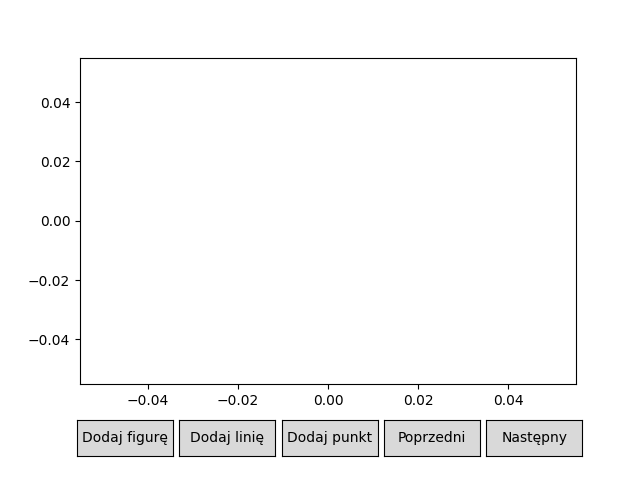

In [4]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [48]:
data1=get_points_from_plot(plot)

<IPython.core.display.Javascript object>


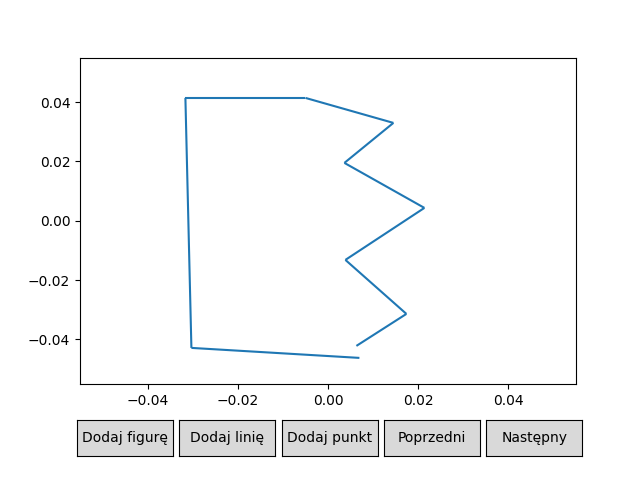

In [6]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [7]:
data2 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


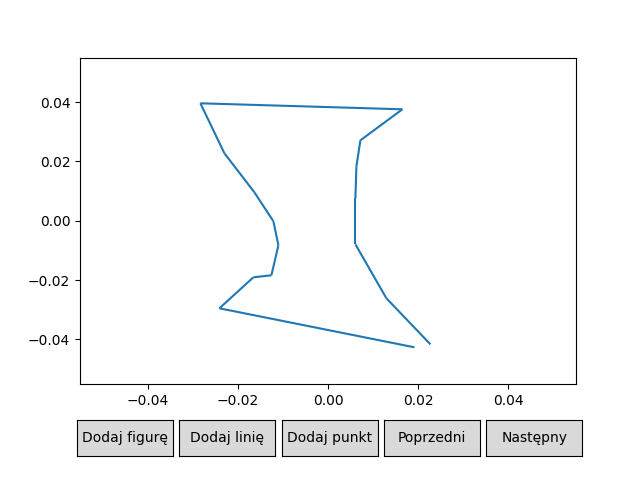

In [8]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [9]:
data3 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


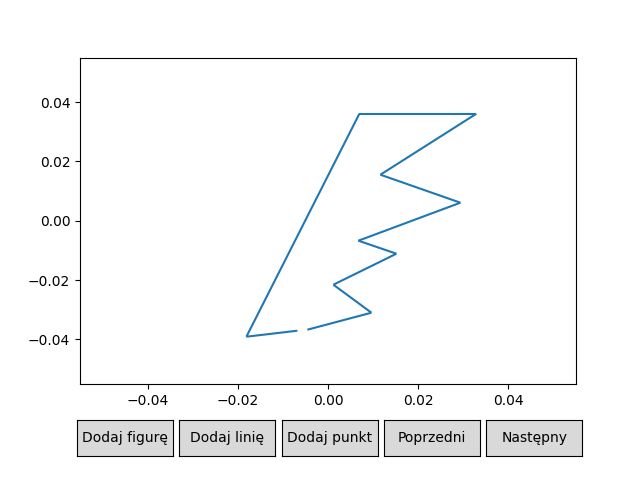

In [10]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [11]:
data4 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


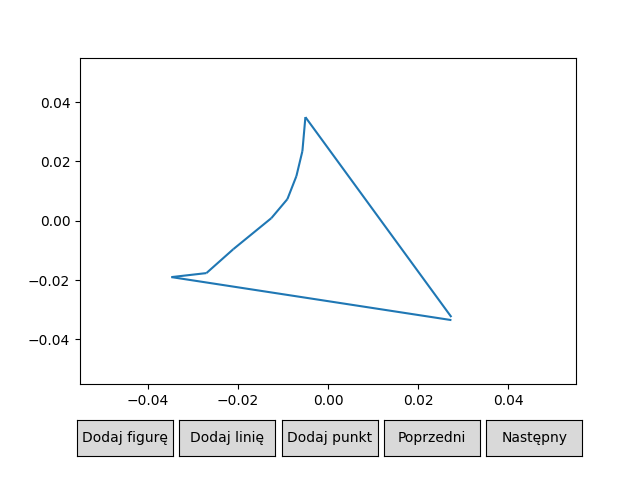

In [12]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [13]:
data5 = get_points_from_plot(plot)

## Zapis punktów do CSV

In [4]:
def save_to_csv(data, name):
    df = pd.DataFrame()
    df['Points']=data
    df.to_csv(name, index=False)

In [34]:
save_to_csv(data1,"Punkty_1.csv")
save_to_csv(data2,"Punkty_2.csv")
save_to_csv(data3,"Punkty_3.csv")
save_to_csv(data4,"Punkty_4.csv")
save_to_csv(data5,"Punkty_5.csv")

## Pobieranie punktów z CSV

In [4]:
def get_points_from_csv(name):
    result=[]
    data=pd.read_csv(name)
    for line in data['Points']:
        line = line.replace("(","")
        line = line.replace(")","")
        line = line.split(", ")
        result.append((float(line[0]),float(line[1])))
    return result

In [5]:
data1=get_points_from_csv("Punkty_1.csv")
data2=get_points_from_csv("Punkty_2.csv")
data3=get_points_from_csv("Punkty_3.csv")
data4=get_points_from_csv("Punkty_4.csv")
data5=get_points_from_csv("Punkty_5.csv")

In [6]:
def maxY_index(points):
    maximum=float('-inf')
    index=-1
    for i in range(len(points)):
        if points[i][1]>maximum:
            maximum=points[i][1]
            index=i
    return index

def minY_index(points):
    minimum=float('inf')
    index=-1
    for i in range(len(points)):
        if points[i][1]<minimum:
            minimum=points[i][1]
            index=i
    return index

def yMonotony(points):
    top=maxY_index(points)
    bottom=minY_index(points)
    i=top
    while i != bottom:
        next_point=(i+1)%len(points)
        if points[next_point][1]>points[i][1]:
            return False       
        i=next_point
    i=bottom
    
    i=bottom
    while i != top:
        next_point=(i+1)%len(points)
        if points[next_point][1]<points[i][1]:
            return False       
        i=next_point
        
    return True

In [7]:
epsilon = 10**(-12)
def matrix_2x2(a,b,c):
    return [[a[0]-c[0], a[1]-c[1]], [ b[0]-c[0], b[1]-c[1]]]

def det_2x2(a,b,c):
    matrix=matrix_2x2(a,b,c)
    return (matrix[0][0]*matrix[1][1])-(matrix[0][1]*matrix[1][0])

def is_in_polygon(a,b,c, number):
    if number == 0:
        return det_2x2(a,b,c) > epsilon
    else:
        return det_2x2(a,b,c) < -epsilon

# Triangulacja z ćwiczeń

In [8]:
def triangulation(points):
    if not yMonotony(points):
        print("Wielokat nie jest y-monotoniczny")
        return None, None
    
    maximum_index = maxY_index(points)
    minimum_index = minY_index(points)
    
    specified_points= []
    i=maximum_index
    while i!=minimum_index:
        specified_points.append((points[i],0,i))
        i=(i+1)%len(points)
    while i!=maximum_index:
        specified_points.append((points[i],1,i))
        i=(i+1)%len(points)
    specified_points.sort(reverse = True, key = lambda x: x[0][1])
    
    diagonals = []
    stack = []
    scenes = []
    diagonal_index=[]
    
    stack.append(specified_points[0])
    stack.append(specified_points[1])
    diagonals.append([specified_points[0][0], specified_points[1][0]])
    diagonal_index.append((specified_points[0][2],specified_points[1][2]))
    scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[0][0]], color="red",
        marker="D")], [LinesCollection(diagonals.copy(), color="black")]))   
    print(diagonals)
    scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[1][0]], 
        color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
    
    for i in range(2, len(specified_points)):
        if stack[-1][1] != specified_points[i][1]:
            while len(stack) > 0:
                new_verticle = stack.pop()
                diagonals.append([new_verticle[0], specified_points[i][0]])
                diagonal_index.append((new_verticle[2],specified_points[i][2]))
                scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            stack.append(specified_points[i-1])
            stack.append(specified_points[i])
        else:
            new_verticle = stack.pop()
            diagonals.append([specified_points[i][0], new_verticle[0]])
            diagonal_index.append((specified_points[i][2],new_verticle[2]))
            scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], 
                color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            while len(stack) > 0 and is_in_polygon(specified_points[i][0], stack[-1][0], new_verticle[0], specified_points[i][1]):
                new_verticle = stack.pop()
                diagonals.append([new_verticle[0], specified_points[i][0]])
                diagonal_index.append((new_verticle[2], specified_points[i][2]))
                scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            stack.append(new_verticle)
            stack.append(specified_points[i])
  
    final_scene = Scene([PointsCollection(points)], [LinesCollection(diagonals.copy(), color="black")])
    scenes = [final_scene] + scenes
                        
    return diagonal_index, scenes

[[(-0.008338711031021614, 0.045794013808755335), (0.015391127678655803, 0.040738866749931796)]]


<IPython.core.display.Javascript object>


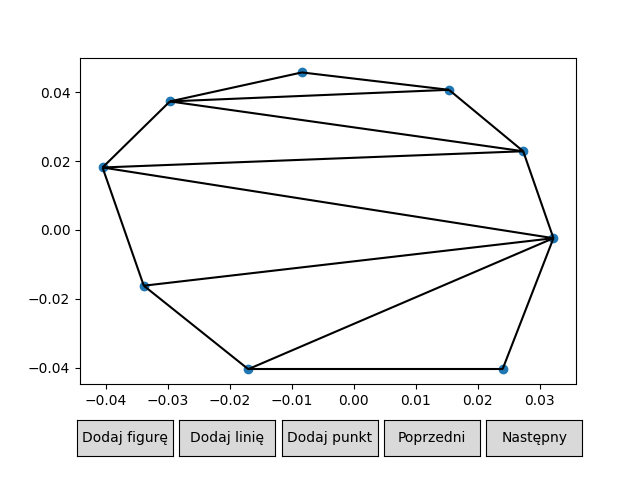

In [9]:
_, data = triangulation(data1)
plot = Plot(data)
plot.draw()

# TRIANGULACJA DELAUNAY'A

In [10]:
def get_points(points):
    result=[]
    for point in points:
        result.append((point.x,point.y))
    return result

In [11]:
def det_3x3(matrix):
    one = (matrix[0][0]*matrix[1][1]*matrix[2][2])+(matrix[1][0]*matrix[2][1]*matrix[0][2])+(matrix[2][0]*matrix[0][1]*matrix[1][2])
    two = (matrix[0][2]*matrix[1][1]*matrix[2][0])+(matrix[0][1]*matrix[1][0]*matrix[2][2])+(matrix[0][0]*matrix[1][2]*matrix[2][1])
    return one-two

In [12]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [13]:
class Triangle:
    def __init__(self, p1: Point, p2: Point, p3: Point):
        self.p1 = p1    # pierwszy punkt
        self.p2 = p2    # drugi punkt
        self.p3 = p3    # trzeci punkt
        self.orient_counterclockwise()   # przypisanie funkcji do ustawienia orientacji punktów przeciwnie do wskazówek zegara
        self.edges = self.determine_edges()  #przypisanie funkcji do wykrywania krawędzi
        return

    def points(self) -> [Point,Point,Point]:
        return [self.p1, self.p2, self.p3]

#     # zwraca środki krawędzi trójkąta
    def determine_edges(self) -> [Point,Point,Point]:

        def midpoint(p1: Point, p2: Point):
            return Point((p1.x + p2.x) / 2, (p1.y + p2.y) / 2)

        return [midpoint(self.p1, self.p2), midpoint(self.p2, self.p3), midpoint(self.p3, self.p1)]
    
    # sprawdzam czy punkty idą w kierunku przeciwnym do wskazówek zegara, jeśli nie to je zamienia
    def orient_counterclockwise(self):
        if det_2x2((self.p3.x, self.p3.y),(self.p2.x, self.p2.y),(self.p1.x,self.p1.y)) > 0 :
            self.p3, self.p2 = self.p2, self.p3
        return 

    # sprawdzenie czy punkt "p" zaiwera się w okręgu opsinaym na trójkącie
    def circumcircle_contains_point(self, p: Point):
        Ax = self.p1.x
        Bx = self.p2.x
        Cx = self.p3.x
        Dx = p.x
        
        Ay = self.p1.y
        By = self.p2.y
        Cy = self.p3.y
        Dy = p.y

        mat = [
            [Ax - Dx, Ay - Dy, (Ax**2 - Dx**2) + (Ay**2 - Dy**2)],
            [Bx - Dx, By - Dy, (Bx**2 - Dx**2) + (By**2 - Dy**2)],
            [Cx - Dx, Cy - Dy, (Cx**2 - Dx**2) + (Cy**2 - Dy**2)]]

        return det_3x3(mat) > 0

In [15]:
class DelaunayTriangulation:
    def __init__(self, points):
        self.points = points
        self.triangles = []
#         self.scenes=[]
        self.triangulate()


    def triangulate(self):
        
            
        def points_overlap(p1: Point, p2: Point):
            return ((p1.x - p2.x)**2 + (p1.y - p2.y)**2)**0.5 <= 1e-6


        def find_solitary_edges(bad_triangles):
            solitary_edges = []

            # Sprawdzanie konfliktów
            for tri_i_index, tri_i in enumerate(np.array(self.triangles)[bad_triangles]):
                for edge_midpoint_i_index, edge_midpoint_i in enumerate(tri_i.edges):
                    no_conflicts = True
                    
                    for tri_j_index, tri_j in enumerate(np.array(self.triangles)[bad_triangles]):
                        if tri_i_index != tri_j_index: # Sprawdzenie czy nie jest porównywany ten sam trójkąt
                            for edge_midpoint_j_index, edge_midpoint_j in enumerate(tri_j.edges):
                                
                                if points_overlap(edge_midpoint_i, edge_midpoint_j):
                                    no_conflicts = False

                    if no_conflicts:
                        p1, p2, p3 = tri_i.p1, tri_i.p2, tri_i.p3

                        if edge_midpoint_i_index == 0:
                            solitary_edges.append((p1, p2))
                        elif edge_midpoint_i_index == 1:
                            solitary_edges.append((p2, p3))    
                        elif edge_midpoint_i_index == 2:
                            solitary_edges.append((p3, p1))
                
            return solitary_edges


        def remove_bad_triangles(bad_triangles):
            bad_triangles.sort(reverse=True)
            for bad_tri in bad_triangles:
                del self.triangles[bad_tri]
            return
        
        self.scenes=[Scene([PointsCollection(get_points(self.points), color="green")],
            [LinesCollection(self.get_lines(), color="black")])]
        

        # Tworzenie trójkąta obejmującego wszystkie punkty:
        x_max = max([p.x for p in self.points])
        y_max = max([p.y for p in self.points])
        x_min = min([p.x for p in self.points])
        y_min = min([p.y for p in self.points])

        s1 = Point(x_min - 2*(x_max - x_min), y_min - (y_max - y_min))
        s2 = Point(x_max + 2*(x_max - x_min), y_min - (y_max - y_min))
        s3 = Point(0, y_max + (y_max - y_min))
   
        super_triangle = Triangle(s1, s2, s3)
        self.triangles.append(super_triangle)
        

        
        for iterate in range(len(self.points)):
            p = self.points[iterate]
            
            #Wizualizacja punktów zawartch w "super trójkącie"
            self.scenes.append(Scene([PointsCollection(get_points(self.points), color="green"),
                PointsCollection([(p.x,p.y)], color="red"),
                PointsCollection([[s1.x,s1.y],[s2.x, s2.y], [s3.x, s3.y]], color="yellow")],
                [LinesCollection(self.get_lines(), color="black")]))
            
            
            
            bad_triangles = []
            for i, tri in enumerate(self.triangles):
                if tri.circumcircle_contains_point(p):
                    bad_triangles.append(i)
                    self.scenes.append(Scene([PointsCollection(get_points(self.points), color="green"),
                        PointsCollection([(p.x,p.y)], color="red"),
                        PointsCollection([[s1.x,s1.y],[s2.x, s2.y], [s3.x, s3.y]], color="yellow")],
                        [LinesCollection(self.get_lines(), color="black"),
                        LinesCollection(self.triangle_to_lines(tri), color="red'")]))
                    print(self.triangle_to_lines(tri))
            
            # Znalezienie złych trójkątów (jeśli w kole opsianym na danym trójkącie znajduje sie punkt P to jest on zły):
            polygon = find_solitary_edges(bad_triangles) 

            # Usunięcie złych trójkątów:
            remove_bad_triangles(bad_triangles)
            
            self.scenes.append(Scene([PointsCollection(get_points(self.points), color="green"),
                PointsCollection([(p.x,p.y)], color="red"),
                PointsCollection([[s1.x,s1.y],[s2.x, s2.y], [s3.x, s3.y]], color="yellow")],
                [LinesCollection(self.get_lines(), color="black")]))
            
            
            # Tworzenie nowych trójkątów z krawędziami wielokąta trzymanymi w solitary_edge:
            for solitary_edge in polygon:
                new_triangle = Triangle(p, solitary_edge[0], solitary_edge[1])
                self.triangles.append(new_triangle)
                
#                 self.scenes.append(Scene([PointsCollection(get_points(self.points), color="green"),
#                     PointsCollection([(p.x,p.y)], color="red"),
#                     PointsCollection([[s1.x,s1.y],[s2.x, s2.y], [s3.x, s3.y]], color="yellow")],
#                     [LinesCollection(self.get_lines(), color="black")]))

        
        # Usuwanie największego trójkąta:
        bad_triangles = []
        for i, triangle in enumerate(self.triangles):
            for point in triangle.points():
                if points_overlap(point, s1) or points_overlap(point, s2) or points_overlap(point, s3):
                    bad_triangles.append(i)
                    break

        remove_bad_triangles(bad_triangles)
        
        self.scenes.append(Scene([PointsCollection(get_points(self.points), color="green"),
            PointsCollection([(p.x,p.y)], color="red")],
            [LinesCollection(self.get_lines(), color="black")]))
        
        return
    
    
    
    def plot(self):
        #return DelaunayTriangulation.scenes
        
        plt.figure()

        for tri in self.triangles:
            plt.plot([tri.p1.x, tri.p2.x, tri.p3.x, tri.p1.x], [tri.p1.y, tri.p2.y, tri.p3.y, tri.p1.y], '-k')
        
        plt.plot([p.x for p in self.points], [p.y for p in self.points], '.r')
        plt.plot([self.points[i%len(self.points)].x for i in range(len(self.points)+1)],
                 [self.points[i%len(self.points)].y for i in range(1+len(self.points))], '-b')
        plt.show()
        return
    

    def get_lines(self):
        result=[]
        for triangle in self.triangles:
            for i in range(3):
                result.append([(triangle.points()[i].x,triangle.points()[i].y),
                    (triangle.points()[(i+1)%3].x, triangle.points()[(i+1)%3].y)])
        return result
    
    def get_convex(self):
        result=[]
        
    def triangle_to_lines(self, point: Point):
        result = []
        for i in range(3):
            p = point.points()
            line = ((p[i].x, p[i].y),(p[(i+1)%3].x, p[(i+1)%3].y))
            result.append(line)
        return result
            
    
#             scenes=[Scene([PointsCollection(get_points(points), color="green"), PointsCollection([specified_points[0][0]], color="red",
#             marker="D")], [LinesCollection(self.get_lines(), color="black")]) ]

## Delaunay:

[((-0.12011290457940872, -0.11421262152054734), (0.13492741800123645, -0.11421262152054734)), ((0.13492741800123645, -0.11421262152054734), (0, 0.11124693730298217)), ((0, 0.11124693730298217), (-0.12011290457940872, -0.11421262152054734))]
[((-0.004568549740699035, -0.03670036661858652), (0.13492741800123645, -0.11421262152054734)), ((0.13492741800123645, -0.11421262152054734), (0, 0.11124693730298217)), ((0, 0.11124693730298217), (-0.004568549740699035, -0.03670036661858652))]
[((-0.004568549740699035, -0.03670036661858652), (0, 0.11124693730298217)), ((0, 0.11124693730298217), (-0.12011290457940872, -0.11421262152054734)), ((-0.12011290457940872, -0.11421262152054734), (-0.004568549740699035, -0.03670036661858652))]
[((0.009624998646397737, -0.030971199951919853), (0, 0.11124693730298217)), ((0, 0.11124693730298217), (-0.004568549740699035, -0.03670036661858652)), ((-0.004568549740699035, -0.03670036661858652), (0.009624998646397737, -0.030971199951919853))]
[((0.009624998646397737,

<IPython.core.display.Javascript object>


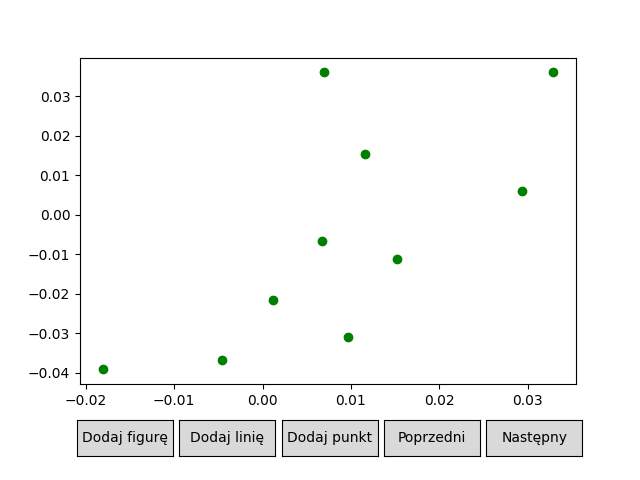

In [16]:
points = [Point(x, y) for x, y in data4]
delaunay = DelaunayTriangulation(points)
# delaunay.plot()
ss = delaunay.scenes
dd  = Plot(scenes = ss)
dd.draw()

## Z ćwiczeń:

[[(0.03291128896897838, 0.03609375102847233), (0.006963708323817097, 0.03609375102847233)]]


/tmp/ipykernel_9711/185121955.py:100: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


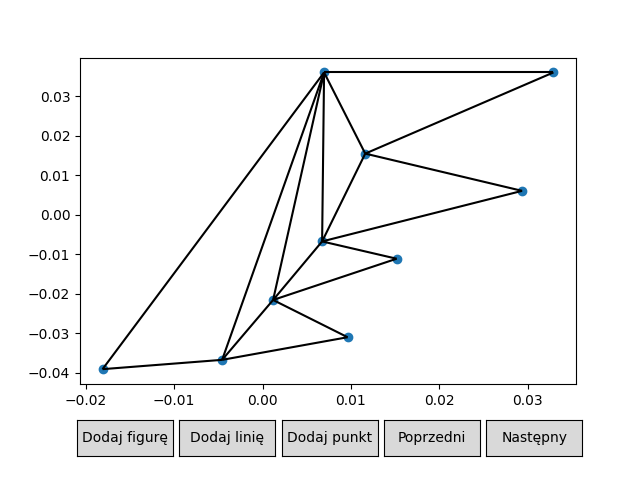

In [102]:
_ , data = triangulation(data4)
plot = Plot(data)
plot.draw()